## Task 1: Choose and defend the best metric for quantifying performance of a model.

### Original Data
From the information below, we can see both Operating/Published Airline IATA Code are containing the null value. Furthermore, both Code features are just an abbreviation for the Operating and Published Airline. So we can discard them first

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('Cargo Volume - Train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27230 entries, 0 to 27229
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Activity Period              27230 non-null  int64  
 1   Operating Airline            27230 non-null  object 
 2   Operating Airline IATA Code  27199 non-null  object 
 3   Published Airline            27230 non-null  object 
 4   Published Airline IATA Code  27199 non-null  object 
 5   GEO Summary                  27230 non-null  object 
 6   GEO Region                   27230 non-null  object 
 7   Activity Type Code           27230 non-null  object 
 8   Cargo Type Code              27230 non-null  object 
 9   Cargo Aircraft Type          27230 non-null  object 
 10  Cargo Metric TONS            27230 non-null  float64
dtypes: float64(1), int64(1), object(9)
memory usage: 2.3+ MB


In [2]:
# Drop Operating Airline IATA Code and Published Airline IATA Code
df = df.drop(['Operating Airline IATA Code', 'Published Airline IATA Code'], axis='columns')

### Encoding
Before we dive into training the data, we would like to check if any features are being unimportant(i.e. not related to target). However, because we cannot really visualize the relationship between the categorized columns and target(Cargo Metric TONS), it's better to transform the categorized features into a number. 

There are many approaches for encoding the categorized dataset. Here, I choose LabelEncoder to encode those features which are not numeric not only because we can have a good view of the dataset, but it does have more reliable performance when training a model. I have also tried to apply one-hot encoding, but it always has a worse MSE(about 20,000) than label encoding. Therefore, I will also use the label encoded dataframe when I am training the data later.

In [3]:
from sklearn.preprocessing import LabelEncoder

# Encoding the dataset in label encoding
labelencoder = LabelEncoder()
label_encoded_df = df.copy()
label_encoded_df['Operating Airline'] = labelencoder.fit_transform(df['Operating Airline'])
label_encoded_df['Published Airline'] = labelencoder.fit_transform(df['Published Airline'])
label_encoded_df['GEO Summary'] = labelencoder.fit_transform(df['GEO Summary'])
label_encoded_df['GEO Region'] = labelencoder.fit_transform(df['GEO Region'])
label_encoded_df['Activity Type Code'] = labelencoder.fit_transform(df['Activity Type Code'])
label_encoded_df['Cargo Type Code'] = labelencoder.fit_transform(df['Cargo Type Code'])
label_encoded_df['Cargo Aircraft Type'] = labelencoder.fit_transform(df['Cargo Aircraft Type'])

In [4]:
label_encoded_df.head()

,Activity Period,Operating Airline,Published Airline,GEO Summary,GEO Region,Activity Type Code,Cargo Type Code,Cargo Aircraft Type,Cargo Metric TONS
0,201601,77,70,0,8,1,0,2,8.871509
1,200811,87,80,0,8,0,0,2,53.946194
2,200709,68,62,1,1,0,1,2,0.043999
3,201608,67,61,1,0,0,2,2,19.023530
4,201708,73,67,1,0,0,1,2,6.951420


### Kernel Density Estimate
We will be able to see the KDE plots after encoding the string values. Right now we can see the distribution of all features. All the features look normal in terms of distribution. So we do not need to discard any features. 

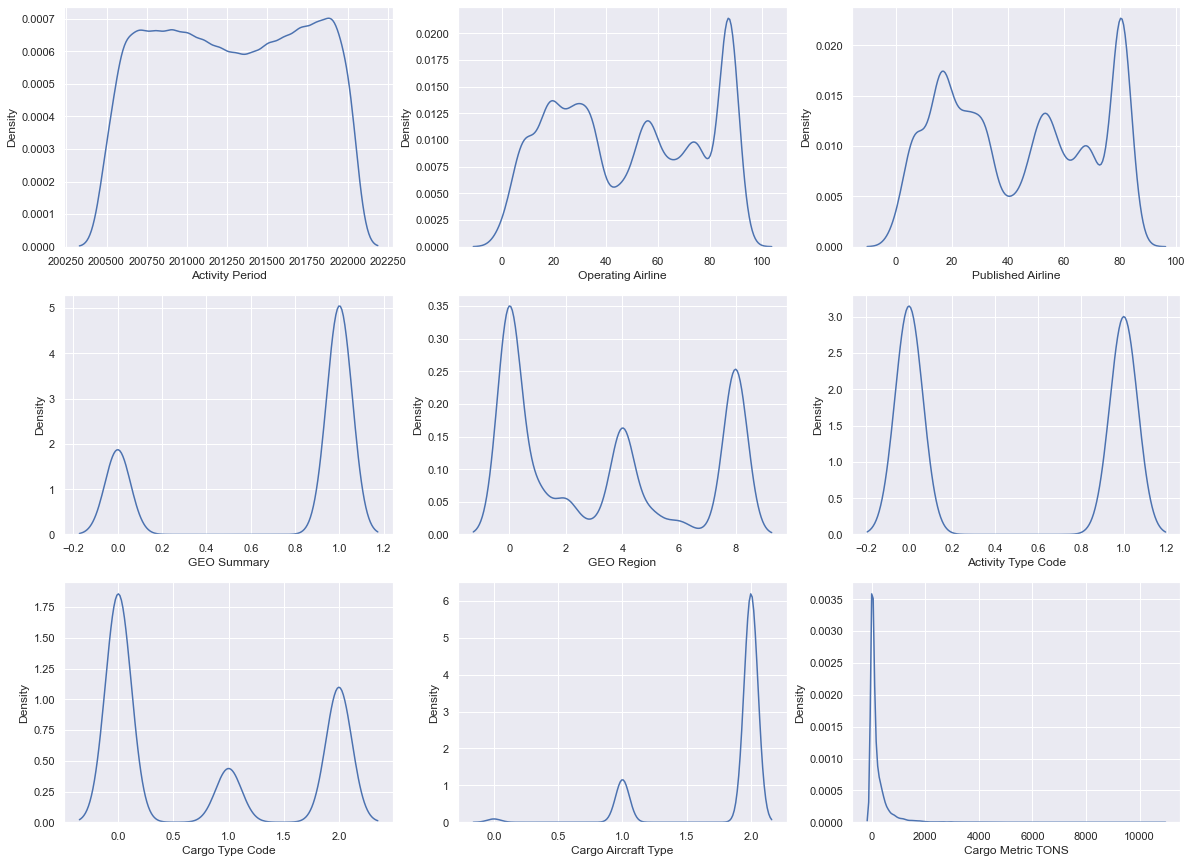

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20,15))
for i in range(len(label_encoded_df.columns)):
    ax_row = int(i/3)
    ax_colm = i % 3
    sns.kdeplot(label_encoded_df.iloc[:, i], ax=axes[ax_row, ax_colm], color='b')

In [6]:
# y: target, x:features
y = label_encoded_df['Cargo Metric TONS']
x = label_encoded_df.drop(['Cargo Metric TONS'], axis="columns")

In [7]:
# Split data to train/test to evaluate the accuracy
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=8)

## Task 2: Produce the best model you can for predicting the target (Cargo Metric Tons) using the train set data.

This is a supervised learning and regression case. So far, we've learned the linear regression, logistic regression, SVM, and tree algorithm do deal with this kind of dataset. I think the linear regression and logistic regression cannot fit well on this dataset because it has too many categorized columns. In other words, most of the features do not have a **linear** relationship. The linear and logistic will definitely cause an awful MSE. 

The svm is not also a good choice for the dataset. It not only takes too much time to complete the training process (a few minutes for label encoding, a few hours for one-hot encoding) but also gets approximately 200,000 MSE, which is literally terrible. 

The decision tree algorithm is very suitable for this dataset since most of the features are categorized(i.e. not a numeric and continuous value). To find out the best performance among all tree algorithms, I do a little comparison here.

### 1. Decision Tree Regressor
Decision tree regressor is the simplest tree algorithm. However, its MSE is always about 17,000 so it may not be accurate enough

In [8]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

regressor = DecisionTreeRegressor()
regressor.fit(train_x, train_y)
hyp = regressor.predict(test_x)
MSE = mean_squared_error(test_y, hyp)
MSE

17346.459855625188

### 2. Random Forest Regressor
Compared with the decision tree, the random forest is more common to fit into categorized data because of its randomness. Moreover, we can always get a better MSE via the random forest than a decision tree.

In this dataset, it does have a much lower MSE than the decision tree.

In [9]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(train_x, train_y)
hyp = rf.predict(test_x)
MSE = mean_squared_error(test_y, hyp)
MSE

11687.35954659187

### 3. Bagging 

Besides the random forest tree, there are other [ensemble methods](https://en.wikipedia.org/wiki/Ensemble_learning) which may improve the performance for decision tree. I will choose the bagging algorithm only because the others do not make a better model(always exceed 20,000 MSE).  

In [10]:
from sklearn.ensemble import BaggingRegressor
bag = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=300, max_samples=0.6)
bag.fit(train_x, train_y)
hyp = bag.predict(test_x)
MSE = mean_squared_error(test_y, hyp)
MSE

11829.72418757105

### Choose a model

The comparison showing above gives us a greater understanding of selecting algorithms to train the model. 
The bagging and random forest will always create a better result than the decision tree, so we can just pick one of them. Actually, although it seems like the MSE from random forest regressor is lower, the result is not always the same every time because of the random data splitting. But each time they get a tight MSE so they can be considered as the equivalent in terms of the accuracy of prediction. 

However, the bagging will always spend more time on training the model(about 6 seconds). On the other hand, the random forest only needs 3 seconds to complete the training. Therefore, I believe the random forest is the most suitable model. Then, I am going to predict the test dataset based on a random forest regressor.


## Task 3: Using the best model, generate predictions for the target on the test set.



In [11]:
# Read train and test dataset
train_df = pd.read_csv('Cargo Volume - Train.csv').drop(['Operating Airline IATA Code', 'Published Airline IATA Code',], axis='columns')
test_df = pd.read_csv('Cargo Volume - Test.csv').drop(['Operating Airline IATA Code', 'Published Airline IATA Code',], axis='columns')

# Round the target column to integer so that the decision tree can use it as a target
train_target = train_df['Cargo Metric TONS']
train_df= train_df.drop('Cargo Metric TONS', axis="columns")

In [12]:
train_df

,Activity Period,Operating Airline,Published Airline,GEO Summary,GEO Region,Activity Type Code,Cargo Type Code,Cargo Aircraft Type
0,201601,Sun Country Airlines,Sun Country Airlines,Domestic,US,Enplaned,Cargo,Passenger
1,200811,United Airlines,United Airlines,Domestic,US,Deplaned,Cargo,Passenger
2,200709,Qantas Airways,Qantas Airways,International,Australia / Oceania,Deplaned,Express,Passenger
3,201608,Philippine Airlines,Philippine Airlines,International,Asia,Deplaned,Mail,Passenger
4,201708,Singapore Airlines,Singapore Airlines,International,Asia,Deplaned,Express,Passenger
...,...,...,...,...,...,...,...,...
27225,201108,United Airlines - Pre 07/01/2013,United Airlines - Pre 07/01/2013,International,Canada,Enplaned,Express,Passenger
27226,200703,Asiana Airlines,Asiana Airlines,International,Asia,Deplaned,Mail,Freighter
27227,201204,US Airways,US Airways,Domestic,US,Deplaned,Cargo,Passenger
27228,201005,Air Canada,Air Canada,International,Canada,Deplaned,Cargo,Passenger


In [13]:
# To make sure both train and test dataset have the same encoded deatures,
# must combine these two dataset first
concat_df = pd.concat([train_df, test_df])

In [14]:
labelencoder = LabelEncoder()
concat_df['Operating Airline'] = labelencoder.fit_transform(concat_df['Operating Airline'])
concat_df['Published Airline'] = labelencoder.fit_transform(concat_df['Published Airline'])
concat_df['GEO Summary'] = labelencoder.fit_transform(concat_df['GEO Summary'])
concat_df['GEO Region'] = labelencoder.fit_transform(concat_df['GEO Region'])
concat_df['Activity Type Code'] = labelencoder.fit_transform(concat_df['Activity Type Code'])
concat_df['Cargo Type Code'] = labelencoder.fit_transform(concat_df['Cargo Type Code'])
concat_df['Cargo Aircraft Type'] = labelencoder.fit_transform(concat_df['Cargo Aircraft Type'])

In [15]:
# Split them to their original size after encoding
train_x = concat_df.iloc[:27230, :]
test_x = concat_df.iloc[27230:, :]

In [16]:
# See the shape of the training and testing data
print(train_x.shape)
print(train_target.shape)
print(test_x.shape)

(27230, 8)
(27230,)
(6807, 8)


In [17]:
# Training and predicting
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(train_x, train_target)
hyp = rf.predict(test_x)

In [18]:
hyp

array([ 56.82539772, 152.25608362, 193.63404715, ...,   0.82298009,
       658.97580067,  23.18661677])

### Result
The predicted data will be in hyp, now we are going to output it as a csv file.

In [19]:
f = open("prediction.csv", "w")
f.write("Cargo Metric Tons\n")
for h in hyp:
    f.write(str(h)+"\n")
f.close()